In [102]:
import pandas as pd
import matplotlib
import numpy as np

# Modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

from tensorflow.keras.utils import plot_model


# visualização e gráficos
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import cycle
import scikitplot as skplt
import seaborn as sns


# Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix

In [103]:
df_train = pd.read_csv("dataset_tratado/train_df.csv")
df_val = pd.read_csv("dataset_tratado/validation_df.csv")
df_test = pd.read_csv("dataset_tratado/test_df.csv")

In [104]:
X_train = df_train.drop('satisfied', axis=1)
y_train = df_train['satisfied'].astype(int)

X_val = df_val.drop('satisfied', axis=1)
y_val = df_val['satisfied'].astype(int)

X_test = df_test.drop('satisfied', axis=1)
y_test = df_test['satisfied'].astype(int)

In [105]:
X_train

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.307692,0.052302,0.8,1.0,1.0,0.6,0.4,1.0,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.564103,0.511712,0.4,0.4,0.4,0.4,0.6,0.8,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.551282,0.073506,0.4,0.4,0.4,0.4,0.8,0.4,0.6,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.256410,0.270800,0.8,0.8,0.8,0.6,0.4,0.8,0.4,0.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.294872,0.188611,1.0,0.2,0.2,0.2,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77923,0.076923,0.197496,0.6,1.0,0.6,0.4,1.0,0.6,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77924,0.423077,0.068053,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77925,0.423077,0.311995,0.6,0.8,0.6,0.8,0.4,0.6,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77926,0.474359,0.158724,0.2,0.2,0.2,0.2,1.0,0.6,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [106]:
y_train

0        0
1        1
2        0
3        0
4        1
        ..
77923    0
77924    0
77925    0
77926    0
77927    0
Name: satisfied, Length: 77928, dtype: int32

In [188]:
# Função para criar o modelo MLP
def create_mlp(input_dim, output_dim, hidden_layers=2, 
               neurons_per_layer=64, activation='relu', dropout_rate=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim=input_dim, 
                    activation=activation, kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    for i in range(hidden_layers):
        model.add(Dense(int(neurons_per_layer/(2**i)), activation=activation, 
                        kernel_regularizer=l2(l2_reg)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(output_dim, activation='sigmoid'))
    return model

In [189]:
# Função para escolher o otimizador
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        return SGD(learning_rate=learning_rate)
    else:
        raise ValueError("O nome do otimizador não é válido.")

In [190]:
#Hyperarametros
input_dim = X_train.shape[1] # Dimensão do vetor de entrada == Número de features
output_dim = 1
hidden_layers = 1
neurons_per_layer = 64
activation = 'relu'
dropout_rate = 0.5
l2_reg = 0.01

learning_rate = 0.0001
optimizer_name = 'adam'

epochs = 100000
patience = 3
loss='binary_crossentropy'
batch_size=64

In [191]:
# Criando o modelo
mlp_model = create_mlp(input_dim, output_dim, hidden_layers, neurons_per_layer, activation, dropout_rate, l2_reg)

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [192]:
# Escolhendo o otimizador
optimizer = get_optimizer(optimizer_name, learning_rate)

In [193]:
# Compilando o modelo
mlp_model.compile(optimizer=optimizer,
                  loss=loss,  
                  metrics=[CategoricalAccuracy(), Precision(), Recall()])

In [194]:
mlp_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,401 (25.00 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

In [195]:
# Callback para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [196]:
# Treinando o modelo
import tensorflow.keras as keras
keras.config.disable_traceback_filtering()
history = mlp_model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

Epoch 1/100000
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 1.0000 - loss: 1.4719 - precision_14: 0.6040 - recall_14: 0.5341 - val_categorical_accuracy: 1.0000 - val_loss: 0.8331 - val_precision_14: 0.7870 - val_recall_14: 0.7976
Epoch 2/100000
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.7974 - precision_14: 0.7867 - recall_14: 0.7582 - val_categorical_accuracy: 1.0000 - val_loss: 0.5622 - val_precision_14: 0.8318 - val_recall_14: 0.8297
Epoch 3/100000
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.5775 - precision_14: 0.8293 - recall_14: 0.7964 - val_categorical_accuracy: 1.0000 - val_loss: 0.4657 - val_precision_14: 0.8618 - val_recall_14: 0.8267
Epoch 4/100000
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.4859 - precision_14: 0.8532 - recall_14: 0.8054 - val_categorical_accuracy: 1.0000 - val_loss: 0.4236 - val_precision_14: 0.8851 - val_recall_14:

In [197]:
#Funções Auxilires
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y_test, y_pred_class, y_pred_scores=None):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Calculate precision, recall, and f1-score
    recall = recall_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y_test, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y_test, y_pred_scores)
        aupr = average_precision_score(y_test, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

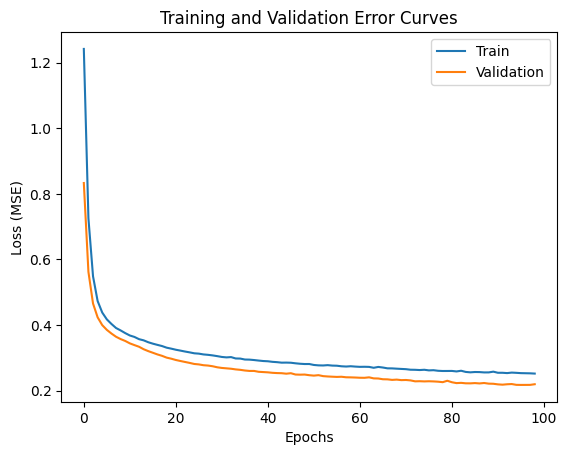

In [198]:
plot_training_error_curves(history)


In [199]:
# Fazer predições no conjunto de teste
y_pred_scores = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_scores, axis=1)
y_pred_class = (y_pred_scores >= 0.5).astype(int)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

3247/3247 ━━━━━━━━━━━━━━━━━━━━ 3s 819us/step


Matriz de confusão no conjunto de teste:


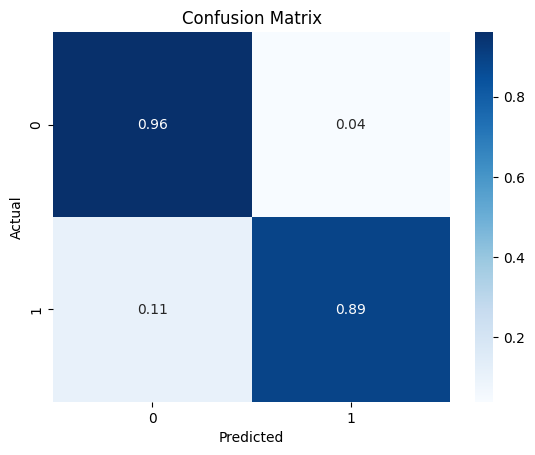

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


Train Loss:       0.2533
Validation Loss:  0.2174

Performance no conjunto de teste:


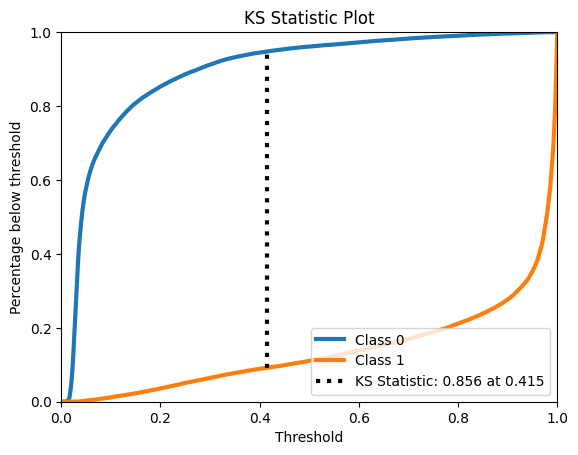


Accuracy:         0.9299
Recall:           0.8894
Precision:        0.9456
F1:               0.9166
AUROC:            0.9820
AUPR:             0.9792


In [207]:
## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Otimização de hyperparametros com hyperopt

In [1]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import hyperopt.pyll.stochastic


In [210]:
# Função objetivo para o Hyperopt
def objective(params):
    input_dim = X_train.shape[1]
    output_dim = 1
    hidden_layers = params['hidden_layers']
    neurons_per_layer = params['neurons_per_layer']
    activation = params['activation']
    dropout_rate = params['dropout_rate']
    l2_reg = params['l2_reg']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    model = create_mlp(input_dim, output_dim, hidden_layers, neurons_per_layer, activation, dropout_rate, l2_reg)
    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall()])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred_val = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    ks = max(tpr - fpr)

    return {'loss': -ks, 'status': STATUS_OK}

In [211]:
# Espaço de busca
space = {
    'hidden_layers': scope.int(hp.quniform('hidden_layers', 1, 3, 1)),
    'neurons_per_layer': scope.int(hp.quniform('neurons_per_layer', 32, 128, 32)),
    'activation': hp.choice('activation', ['relu', 'tanh', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5),
    'l2_reg': hp.uniform('l2_reg', 0.0, 0.1),
    'learning_rate': hp.loguniform('learning_rate', -5, -3),
    'optimizer': hp.choice('optimizer', ['adadelta', 'adam', 'rmsprop', 'sgd']),
}

In [214]:
print(hyperopt.pyll.stochastic.sample(space))

{'activation': 'sigmoid', 'dropout_rate': 0.16837269093540402, 'hidden_layers': 3, 'l2_reg': 0.031108623272863768, 'learning_rate': 0.009846924976265933, 'neurons_per_layer': 32, 'optimizer': 'adam'}


In [212]:
# Otimização
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step
 51/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
101/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/812 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
212/812 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
269/812 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
330/812 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
386/812 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
445/812 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
505/812 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
561/812 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
618/812 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
675/812 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
726/812 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
783/812 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step

  2%|▏         | 1/50 [00:13<11:05, 13.58s/trial, best loss: -0.0]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step
 49/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
102/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
158/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
220/812 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
281/812 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
339/812 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
393/812 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
434/812 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
481/812 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
524/812 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
558/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
602/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
647/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
697/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
757/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

  4%|▍         | 2/50 [00:29<11:52, 14.84s/trial, best loss: -0.0]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step
 49/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 96/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
147/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
200/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
250/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
293/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
344/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
386/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
427/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
467/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
512/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
564/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
616/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
663/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
709/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
750/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
792/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

  6%|▌         | 3/50 [01:42<32:36, 41.63s/trial, best loss: -0.7326722275996574]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step              
 42/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
 89/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
133/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
181/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
222/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
251/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
299/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
339/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
384/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
436/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
487/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
536/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
581/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
634/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
682/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
729/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
772/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step      

  8%|▊         | 4/50 [01:54<22:59, 29.99s/trial,

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step              
 38/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step               
 82/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
128/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
172/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
221/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
265/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
309/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
349/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
393/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
437/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
477/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
522/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
565/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
612/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
657/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
704/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
750/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
794/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step              
 35/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step               
 69/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step      
105/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step      
142/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
179/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
211/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
244/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
281/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
324/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
365/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
404/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
446/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
484/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
523/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
561/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
600/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
640/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
678/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
715/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
752/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step             
 43/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
 89/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
134/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
178/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
224/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
268/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
356/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
396/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
438/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
483/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
533/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
577/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
622/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
668/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
712/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
757/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
803/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step     

 14%|█▍        | 7/50 [05:12<33:47, 47.14s/trial, best loss: -0.73276

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step             
 40/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step              
 79/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
120/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
162/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
200/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
237/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
279/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
322/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
359/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
396/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
433/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
469/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
503/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
539/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
567/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
596/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
633/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
672/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
711/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
750/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
790/812 ━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 1:10 87ms/step            
 32/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step               
 63/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
 99/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
135/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
173/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
210/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
253/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
284/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
349/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
394/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
435/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
474/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
509/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
543/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
577/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
580/812 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step     
616/812 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step     
652/812 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step     
684/812 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step     
717/812 ━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step             
 39/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step              
 55/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
 85/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
126/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step     
171/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
207/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
242/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
284/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
325/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
372/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
424/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
475/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
529/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
577/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
625/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
666/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
710/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
758/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
802/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step     
812/812 ━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step              
 25/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step               
 64/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step      
112/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
163/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
220/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
270/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
324/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
380/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
432/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
477/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
532/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
581/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
637/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
688/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
739/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
786/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step      
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step      

 22%|██▏       | 11/50 [09:05<43:40, 67.20s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step               
 40/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                
 81/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
121/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
163/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
194/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
229/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
268/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
357/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
395/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
437/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
478/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
525/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
573/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
625/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
683/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
741/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
798/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step               
 47/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
109/812 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step     
173/812 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step     
235/812 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step     
297/812 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step     
358/812 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step     
412/812 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step     
458/812 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step     
520/812 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step     
578/812 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step     
639/812 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step     
696/812 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step     
757/812 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step     

 26%|██▌       | 13/50 [09:47<27:05, 43.93s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step               
 51/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
108/812 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step     
163/812 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step     
221/812 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step     
273/812 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step     
328/812 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step     
380/812 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step     
436/812 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step     
489/812 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step     
544/812 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step     
600/812 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step     
640/812 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step     
694/812 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step     
751/812 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step     
802/812 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step     

 28%|██▊       | 14/50 [10:06<21:54, 36.53s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step               
 58/812 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step     
123/812 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step     
188/812 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step     
255/812 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step     
318/812 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step     
384/812 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step     
420/812 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step     
461/812 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step     
498/812 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step     
547/812 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step     
592/812 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step     
650/812 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step     
700/812 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step     
753/812 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step     
803/812 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step     

 30%|███       | 15/50 [10:25<18:14, 31.27s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step               
 53/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step     
111/812 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step     
155/812 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step     
205/812 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step     
257/812 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step     
318/812 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step     
379/812 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step     
437/812 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step     
494/812 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step     
552/812 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step     
609/812 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step     
670/812 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step     
725/812 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step     
784/812 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step     

 32%|███▏      | 16/50 [10:37<14:26, 25.49s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step               
 47/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
100/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
155/812 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step     
207/812 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step     
259/812 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step     
311/812 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step     
364/812 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step     
419/812 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step     
473/812 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step     
530/812 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step     
586/812 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step     
641/812 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step     
696/812 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step     
751/812 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step     
806/812 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step     

 34%|███▍      | 17/50 [11:22<17:07, 31.14s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step               
 55/812 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step     
108/812 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step     
160/812 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step     
210/812 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step     
261/812 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step     
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step     
364/812 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step     
418/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step     
470/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step     
520/812 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step     
570/812 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step     
621/812 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step     
674/812 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step     
724/812 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step     
777/812 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 36%|███▌      | 18/50 [11:38<14:10, 26.57s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step               
 53/812 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step     
113/812 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step     
172/812 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step     
229/812 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step     
285/812 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step     
338/812 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step     
390/812 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step     
447/812 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step     
502/812 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step     
557/812 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step     
611/812 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step     
666/812 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step     
721/812 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step     
776/812 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step     

 38%|███▊      | 19/50 [12:01<13:11, 25.52s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step               
 61/812 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step     
121/812 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step     
180/812 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step     
233/812 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step     
289/812 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step     
347/812 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step     
404/812 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step     
462/812 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step     
521/812 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step     
577/812 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step     
630/812 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step     
687/812 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step     
745/812 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step     
799/812 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step     

 40%|████      | 20/50 [12:55<17:01, 34.05s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step               
 49/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
101/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
156/812 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step     
208/812 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step     
260/812 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step     
316/812 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step     
370/812 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step     
424/812 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step     
472/812 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step     
516/812 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step     
568/812 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step     
623/812 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step     
676/812 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step     
732/812 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step     
786/812 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 42%|████▏     | 21/50 [15:00<29:38, 61.34s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step               
 48/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 98/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
148/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
197/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
251/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
305/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step    
359/812 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step      
412/812 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step     
464/812 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step     
519/812 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step     
564/812 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step     
609/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
657/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
704/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
757/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
807/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 44%|████▍     | 22/50 [17:19<39:36, 84.88s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step               
 55/812 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step     
109/812 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step     
165/812 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step     
227/812 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step     
283/812 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step     
350/812 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step     
412/812 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step     
461/812 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step     
506/812 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step     
563/812 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step     
620/812 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step     
678/812 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step     
733/812 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step     
793/812 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step     

 46%|████▌     | 23/50 [19:02<40:32, 90.09s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step               
 40/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                
 77/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
121/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
166/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
211/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
255/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
297/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
342/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
385/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
426/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
466/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
508/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
548/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
585/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
626/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
667/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
706/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
743/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
782/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step                
 43/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 85/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
128/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
175/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
222/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
270/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
318/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
365/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
408/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
450/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
490/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
541/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
585/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
604/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
639/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
674/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
716/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
760/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
801/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step                
 44/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 85/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
133/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
178/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
227/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
277/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
326/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
362/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
411/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
459/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
512/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
552/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
598/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
645/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
688/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
734/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
777/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step        

 52%|████

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step                
 38/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                 
 77/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
122/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
170/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
214/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
260/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
302/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
347/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
396/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
435/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
479/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
523/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
570/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
621/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
667/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
709/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
750/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
794/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
8

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step                
 46/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 83/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
129/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
178/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
226/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
269/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
309/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
355/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
401/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
446/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
489/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
534/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
573/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
619/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
656/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
698/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
738/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
785/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step                
 46/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 87/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
131/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
171/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
217/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
261/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
307/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
353/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
396/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
442/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
487/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
532/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
577/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
618/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
665/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
712/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
752/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
791/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step               
 41/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 84/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
126/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
171/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
217/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
259/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
304/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
349/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
395/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
437/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
476/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
515/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
556/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
599/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
649/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
695/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
739/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
779/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step                
 36/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                 
 76/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
117/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
158/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
190/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
228/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
272/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
316/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
370/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
417/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
462/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
502/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
545/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
590/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
632/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
679/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
725/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
770/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
8

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step                
 38/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                 
 79/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
119/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
157/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
195/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
242/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
281/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
321/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
362/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
405/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
449/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
491/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
532/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
574/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
617/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
660/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
698/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
738/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
780/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
8

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step                
 40/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                 
 84/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
128/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
173/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
219/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
265/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
308/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
354/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
400/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
443/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
487/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
535/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
591/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
629/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
672/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
714/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
760/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
803/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step        



d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step                
 44/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 87/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
123/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
160/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
203/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
240/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
278/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
315/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
351/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
392/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
430/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
472/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
514/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
557/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
601/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
644/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
686/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
727/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
765/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
806/812 ━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step               
 42/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 75/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
116/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
158/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
202/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
242/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
280/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
323/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
365/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
411/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
449/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
490/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
534/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
578/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
613/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
657/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
697/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
731/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
769/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
807/812 ━━━━━━━━━━━━━━━━━━━━ 0

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step                
 45/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 89/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
125/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
161/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
203/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
248/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
294/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
338/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
386/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
438/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
488/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
537/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
584/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
638/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
691/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
738/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
758/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
790/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 50s 62ms/step               
 39/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                
 87/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
137/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
192/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
234/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
253/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
287/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
326/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
377/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
430/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
479/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
518/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
561/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
601/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
646/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
701/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
755/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
801/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step               
 44/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 86/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
124/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
163/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
201/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
241/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
284/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
330/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
366/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
409/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
455/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
499/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
551/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
600/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
646/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
694/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
744/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
785/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step               
 39/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                
 75/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
107/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
148/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
192/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
237/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
280/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
320/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
358/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
397/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
439/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
477/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
520/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
555/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
593/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
628/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
664/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
701/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
740/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
779/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step               
 35/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step                
 70/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
104/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
141/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
182/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
228/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
269/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
309/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
352/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
392/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
432/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
472/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
512/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
552/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
595/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
634/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
670/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
713/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
756/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
798/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step               
 33/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step                
 64/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step       
105/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       
150/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
191/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
232/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
268/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
306/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
347/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
390/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
430/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
473/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
513/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
550/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
588/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
624/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
661/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
698/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
736/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
777/812 ━━━━━━━━━━━━━

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step               
 41/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 85/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
127/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
169/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
212/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
255/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
297/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
342/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
382/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
424/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
459/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
498/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
540/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
586/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
631/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
671/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
715/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
756/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
803/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step               
 42/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 78/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
117/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
166/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
223/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
265/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
360/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
409/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
457/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
501/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
550/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
599/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
647/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
698/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
744/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
794/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 86%|████████▌ | 43/50 [52:38

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step               
 48/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 91/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
138/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
187/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
227/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
269/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
313/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
356/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
397/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
439/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
487/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
533/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
583/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
630/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
681/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
730/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
777/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 88%|████████▊ | 44/50 [53:01

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step               
 42/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 79/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
123/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
165/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
212/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
258/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
301/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
346/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
392/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
437/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
483/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
533/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
571/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
614/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
652/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
696/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
744/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
789/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step                
 46/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
 92/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
145/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
197/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
247/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
300/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
349/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
397/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
448/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
491/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
542/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
596/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
642/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
689/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
736/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
789/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step        
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step        

 92%|█████████▏| 46/50 [56:30<05:04, 76.16s/trial, best lo

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step               
 48/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 91/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
143/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
192/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
241/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
295/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
345/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
393/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
444/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
492/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
543/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
592/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
642/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
694/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
746/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
794/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 94%|█████████▍| 47/50 [56:49<02:57, 59.18s/trial, best loss: -0.8987628397811155]

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step               
 46/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 89/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
128/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
171/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
218/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
261/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
309/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
353/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
400/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
451/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
499/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
545/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
595/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
643/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
693/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
742/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
788/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 96%|█████████▌| 48/50 [57:13

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step               
 44/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
 88/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
132/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
176/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
224/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
263/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
304/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
349/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
394/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
442/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
491/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
541/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
587/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
624/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
671/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
720/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
767/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

 98%|█████████▊| 49/50 [58:08

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/812 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step               
 52/812 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step     
101/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
154/812 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step     
208/812 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step     
264/812 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step     
311/812 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step     
362/812 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step     
418/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step     
469/812 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step     
522/812 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step     
573/812 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step     
621/812 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step     
674/812 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step     
732/812 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step     
783/812 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step     
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step       
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step       

100%|██████████| 50/50 [58:49<00:00, 70.60s/trial, best loss: -0.8987628397811155]


In [215]:
print("Melhores parâmetros:", best)

Melhores parâmetros: {'activation': 0, 'dropout_rate': 0.034839388578570496, 'hidden_layers': 2.0, 'l2_reg': 0.0002214270633889015, 'learning_rate': 0.007938880708198042, 'neurons_per_layer': 128.0, 'optimizer': 3}


In [216]:
# Re-treinar o modelo com os melhores hiperparâmetros
best_hyperparams = {
    'hidden_layers': int(best['hidden_layers']),
    'neurons_per_layer': int(best['neurons_per_layer']),
    'activation': ['relu', 'tanh', 'sigmoid'][best['activation']],
    'dropout_rate': best['dropout_rate'],
    'l2_reg': best['l2_reg'],
    'learning_rate': best['learning_rate'],
    'optimizer': ['adadelta', 'adam', 'rmsprop', 'sgd'][best['optimizer']],
}

In [217]:
input_dim = X_train.shape[1]
output_dim = 1

In [218]:
mlp_model = create_mlp(input_dim, output_dim, 
                       best_hyperparams['hidden_layers'], 
                       best_hyperparams['neurons_per_layer'], 
                       best_hyperparams['activation'], 
                       best_hyperparams['dropout_rate'], 
                       best_hyperparams['l2_reg'])

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [219]:
optimizer = get_optimizer(best_hyperparams['optimizer'], best_hyperparams['learning_rate'])

In [220]:
mlp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall()])

In [226]:
mlp_model.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_242 (Dense)               │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,187 (114.02 KB)

 Trainable params: 29,185 (114.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [221]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [222]:
history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

In [223]:
# Avaliar o modelo no conjunto de teste
y_pred_scores = mlp_model.predict(X_test)
y_pred_class = (y_pred_scores >= 0.5).astype(int)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

3247/3247 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step


Matriz de confusão no conjunto de teste:


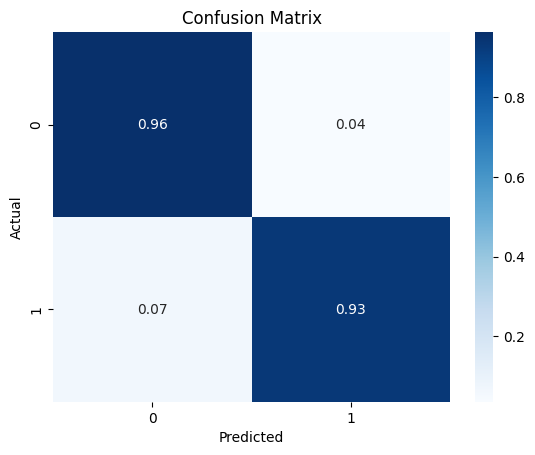

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


Train Loss:       0.1859
Validation Loss:  0.1784

Performance no conjunto de teste:


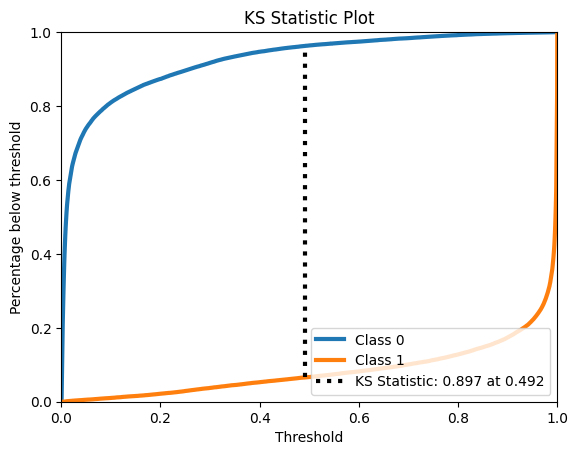


Accuracy:         0.9506
Recall:           0.9333
Precision:        0.9518
F1:               0.9425
AUROC:            0.9902
AUPR:             0.9888


In [225]:
## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)